#### Project 3: Sentiment Analysis of Reviews
The purpose of this notebook is to perform sentiment analysis on reviews using the Yelp Fusion API. The code below uses my client ID and API key to search for at least 60 reviews on businesses selling crepes, clean the reviews, and perform analysis using TextBlob and NaiveBayesAnalyzer to calulate the sentiments, NLTK to remove the stop-words, and WordCloud to generate a visual analysis
- Yashi Bajpai
- CMP-262 (In-Person)
- December 4, 2024

#### ———  code setup

↓ importing libraries

In [ ]:
from __future__ import print_function 
import os 
import sys
import re
import json
import pprint
import argparse
import urllib
from urllib.parse import quote
import requests
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator 
import yelpkeys  # file containing client_id and api_key for yelp fusion API

In [ ]:
api_key = yelpkeys.api_key # constant variable containing API key
headers = { # bearer token for API authorization (needed when accessing reviews)
    'Authorization': f'{api_key}'
}

#### ———  yelp fusion API code

↓ uses Yelp Fusion's search API to query for businesses by the search term 'crepe' and location 'Morris Plains, NJ' and uses Yelp Fusion's business API to query additional information from the searches - code is from ms. binowski's starter code

In [395]:
# constants for API 
API_HOST = 'https://api.yelp.com' # base URL for yelp API
SEARCH_PATH = '/v3/businesses/search' # endpoint for business search
BUSINESS_PATH = '/v3/businesses/'  # endpoint for specific business details, business ID will come after slash.

# constant variables
DEFAULT_TERM = 'crepes' # default search term
DEFAULT_LOCATION = 'Morris Plains, NJ' # default search location
SEARCH_LIMIT = 20 # maximum number of search results to return

"""
Given the API_KEY, sends a GET request to the API.
Args:
    host (str): The domain host of the API.
    path (str): The path of the API after the domain.
    API_KEY (str): Your API Key.
    url_params (dict): An optional set of query parameters in the request.
Returns:
    dict: The JSON response from the request.
Raises:
    HTTPError: An error occurs from the HTTP request.
"""
def request(host, path, api_key, url_params=None):
    url_params = url_params or {} # sets URL to the provided URL parameters or uses empty dictionary if no URL parameters provided
    url = '{0}{1}'.format(host, quote(path.encode('utf8'))) # builds full URL
    headers = { # authorizes access to the data using bearer token
        'Authorization': 'Bearer %s' % api_key, 
    }

    print(u'Querying {0} ...'.format(url)) # logs the request

    response = requests.request('GET', url, headers=headers, params=url_params) # sends GET request

    return response.json() # returns response as JSON

"""
Queries the Search API by a search term and location.
Args:
    term (str): The search term passed to the API.
    location (str): The search location passed to the API.
Returns:
    dict: The JSON response from the request.
"""
def search(api_key, term, location):
    url_params = { 
        'term': term.replace(' ', '+'), # formats earch term for URL
        'location': location.replace(' ', '+'), # formats location for URL
        'limit': SEARCH_LIMIT # limits the results to the defined search limit
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params) # returns the search request


"""
Queries the Business API by a business ID.
Args:
    business_id (str): The ID of the business to query.
Returns:
    dict: The JSON response from the request.
"""
def get_business(api_key, business_id):
    business_path = BUSINESS_PATH + business_id # appends business id to endpoint

    return request(API_HOST, business_path, api_key) # sends request to get business details

"""
Queries the API by the input values from the user.
Args:
    term (str): The search term to query.
    location (str): The location of the business to query.
"""
def query_api(term, location):
    response = search(api_key, term, location) # gets search results

    businesses = response.get('businesses') # extracts the business list from response

    if not businesses: # handles case where no businesses are found
        print(u'No businesses for {0} in {1} found.'.format(term, location)) # prints no businesses for the term and location are found
        return # returns to main

    business_id = businesses[0]['id'] # gets the ID of the top business result 

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id)) # logs the top result query
    response = get_business(api_key, business_id) # gets detailed info for the top business

    print(u'Result for business "{0}" found:'.format(business_id)) # logs result
    pprint.pprint(response, indent=2) # pretty prints the business details

↓ calls the search function - using the API key, returns crepe businesses located in or near Morris Plains, NJ

In [397]:
response = search(api_key,DEFAULT_TERM, 'Morris Plains, NJ') # searches for the default term (crepes) in the location (Morris Plains) using provided API key

Querying https://api.yelp.com/v3/businesses/search ...


↓ prints the queried businesses

In [399]:
response # prints the variable holding the JSON response from the API request

{'businesses': [{'id': 'wlojG-16g80Btl5cuHVsNg',
   'alias': 'el-coqui-crepes-denville',
   'name': 'El Coqui Crepes',
   'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/pWAKSQY-afJKVWswlLF3Fg/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/el-coqui-crepes-denville?adjust_creative=istl9jgw2i0Hp64EIdomvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=istl9jgw2i0Hp64EIdomvQ',
   'review_count': 17,
   'categories': [{'alias': 'creperies', 'title': 'Creperies'},
    {'alias': 'bars', 'title': 'Bars'},
    {'alias': 'juicebars', 'title': 'Juice Bars & Smoothies'}],
   'rating': 4.8,
   'coordinates': {'latitude': 40.89225713693323, 'longitude': -74.4784078},
   'transactions': [],
   'location': {'address1': '5 Broadway Ave',
    'address2': '',
    'address3': None,
    'city': 'Denville',
    'zip_code': '07834',
    'country': 'US',
    'state': 'NJ',
    'display_address': ['5 Broadway Ave', 'Denville, NJ 07834']},
   'phone': '+197345361

#### ———  analyzing the sentiments

↓ code to analyze sentiments using TextBlob and writes the reviews to a file

In [440]:
pos_count = 0 # counter for positive sentiment reviews
neg_count = 0 # counter for negative sentiment reviews
neu_count = 0 # counter for neutral sentiment reviews

output_file = 'business_reviews.txt' # specifies the output file for storing business reviews
with open(output_file, 'w', encoding='utf-8') as file: #  opens the file in write mode with utf-8 encoding
    for business in response['businesses']: # iterates through each business in the API response
        print('Business Name: ' + business['name']) # prints business name
        print('Rating: ' + str(business['rating'])) # prints business rating
        print('Review Count: ' + str(business['review_count'])) # prints number of reviews
        print('Reviews: ') # indicates start of reviews section

        file.write('Business Name: ' + business['name'] + '\n') # writes business name to file
        file.write('Rating: ' + str(business['rating']) + '\n') # writes business rating to file
        file.write('Review Count: ' + str(business['review_count']) + '\n') # writes review count to file
        file.write('Reviews:\n') # writes reviews to file
        
        BUS_REVIEW = '/v3/businesses/{}/reviews'.format(business['id']) # constructs endpoint for fetching reviews
        reviews = request(API_HOST, BUS_REVIEW, headers['Authorization']) # fetches the reviews using the API request
        
        if 'reviews' in reviews: # checks if reviews are present in the response
            for review in reviews['reviews']: # iterates through each review
                review_text = review['text'].replace('\n', ' ').strip() # cleans and formats review text
                file.write('• ' + review_text + '\n') # writes formatted review to file
                print('- ' + review_text) # prints formatted review
                
                # performs sentiment analysis using TextBlob
                blob = TextBlob(review['text']) # creates TextBlob object for the review text
                sentiment = blob.sentiment.polarity # gets the sentiment polarity score
                if sentiment > 0: # if the sentiment is positive
                    pos_count += 1 # increments positive counter
                    print('  Sentiment: Positive') # prints that the sentiment is positive
                    file.write('  Sentiment: Positive\n') # writes to the file that the sentiment is positive
                elif sentiment < 0: # if the sentiment is negative
                    neg_count += 1 # increments negative counter
                    print('  Sentiment: Negative') # prints that the sentiment is negative
                    file.write('  Sentiment: Negative\n') # writes to the file that the sentiment is negative
                else: # if the sentiment is neutral
                    neu_count += 1 # increments neutral counter
                    print('  Sentiment: Neutral') # prints that the sentiment is neutral
                    file.write('  Sentiment: Neutral\n') # writes to the file that the sentiment is neutral
        else: # handles case where no reviews are found
            print('No reviews found for this business.') # prints if no reviews are found
            file.write('No reviews found for this business.\n') # writes to file if no reviews are found
        
        print('\n=================\n') # prints separator for readability
        file.write('\n=================\n') # writes to file separator for readability

print(f'Reviews saved to {output_file}') # confirm that the reviews saved to output file

Business Name: El Coqui Crepes
Rating: 4.8
Review Count: 17
Reviews: 
/v3/businesses/wlojG-16g80Btl5cuHVsNg/reviews
Querying https://api.yelp.com/v3/businesses/wlojG-16g80Btl5cuHVsNg/reviews ...
- If you like crepes, this is the place for you! My wife is a huge fan so this new restaurant in Denville was like a dream come true. The restaurant is really...
  Sentiment: Positive
- This place is absolutely adorable, and just what they needed nestled in the heart of Denville, a true, Puerto Rican, gem!  They have a limited time Barbie...
  Sentiment: Positive
- If you live in New Jersey this place is a MUST TRY! I absolutely love the decor and how beautiful this place is. I love the swing and the treat yourself...
  Sentiment: Positive


Business Name: Noon Tea Creperie
Rating: 4.3
Review Count: 81
Reviews: 
/v3/businesses/SMP3AT9mc_7WamIQLiLGwg/reviews
Querying https://api.yelp.com/v3/businesses/SMP3AT9mc_7WamIQLiLGwg/reviews ...
- Delicious thai milk tea! Have tried it a few times now. Se

↓ code to make donut chart of TextBlob sentiments - part of the code is from ms. binowski's starter code

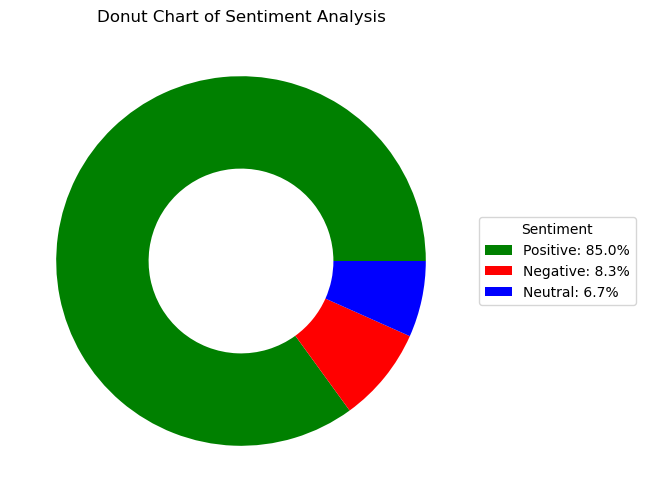

In [404]:
pos = pos_count # assigns positive sentiment count to pos
neg = neg_count # assigns negative sentiment count to neg
neu = neu_count # assigns neutral sentiment count to neu

labels = ['Positive', 'Negative', 'Neutral'] # defines labels for sentiment categories
values = [pos, neg, neu] # stores sentiment counts in a list

percentages = [f'{label}: {value/sum(values)*100:.1f}%' for label, value in zip(labels, values)] # # calculates percentages for each sentiment category and formats them as strings (courtesy of chatgpt)

# creates donut chart
fig, ax = plt.subplots(figsize=(6, 6)) # initializes figure and axes with specified size
ax.pie(values, labels=None, wedgeprops=dict(width=0.5), colors=['green', 'red', 'blue']) # plots a pie chart with sentiment values, sets width for donut effect, and assigns colors
ax.legend(percentages, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)) # adds a legend with sentiment percentages and positions it to the right of the chart

ax.set_title('Donut Chart of Sentiment Analysis') # sets the chart title

plt.show() # displays the chart

↓ code to analyze sentiments using NaiveBayesAnalyzer

In [406]:
pos_count = 0 # counter for positive sentiment reviews
neg_count = 0 # counter for negative sentiment reviews

for business in response['businesses']: # iterates through each business in the API response
    print('Business Name: ' + business['name']) # prints business name
    print('Rating: ' + str(business['rating'])) # prints business rating
    print('Review Count: ' + str(business['review_count'])) # prints number of reviews
    print('Reviews: ') # indicates start of reviews section
    
    BUS_REVIEW = '/v3/businesses/{}/reviews'.format(business['id']) # constructs endpoint for fetching reviews
    reviews = request(API_HOST, BUS_REVIEW, headers['Authorization']) # fetches the reviews using the API request
    
    if 'reviews' in reviews: # checks if reviews are present in the response
        for review in reviews['reviews']: # iterates through each review
            print('- ' + review['text'].replace('\n', ' ').strip()) # prints reviews & cleans and formats review text
            
            # performs sentiment analysis using NaiveBayesAnalyzer
            blob = TextBlob(review['text'], analyzer=NaiveBayesAnalyzer()) # creates TextBlob object for the review text
            sentiment = blob.sentiment.classification  # gets the sentiment polarity score
            
            if sentiment == 'pos': # if the sentiment is positive
                pos_count += 1 # increments positive counter
                print('  Sentiment: Positive') # prints that the sentiment is positive
            elif sentiment == 'neg': # if the sentiment is negative
                neg_count += 1 # increments negative counter
                print('  Sentiment: Negative') # prints that the sentiment is negative
    else: # handles case where no reviews are found
        print('No reviews found for this business.') # prints if no reviews are found
    
    print('\n=================\n') # prints separator for readability

Business Name: El Coqui Crepes
Rating: 4.8
Review Count: 17
Reviews: 
Querying https://api.yelp.com/v3/businesses/wlojG-16g80Btl5cuHVsNg/reviews ...
- If you like crepes, this is the place for you! My wife is a huge fan so this new restaurant in Denville was like a dream come true. The restaurant is really...
  Sentiment: Positive
- This place is absolutely adorable, and just what they needed nestled in the heart of Denville, a true, Puerto Rican, gem!  They have a limited time Barbie...
  Sentiment: Positive
- If you live in New Jersey this place is a MUST TRY! I absolutely love the decor and how beautiful this place is. I love the swing and the treat yourself...
  Sentiment: Positive


Business Name: Noon Tea Creperie
Rating: 4.3
Review Count: 81
Reviews: 
Querying https://api.yelp.com/v3/businesses/SMP3AT9mc_7WamIQLiLGwg/reviews ...
- Delicious thai milk tea! Have tried it a few times now. Service was quick and friendly. Some space to sit inside and out but it fills up quick. Love t

↓ code to make donut chart of NaiveBayesAnalyzer sentiments - - code is from ms. binowski's starter code

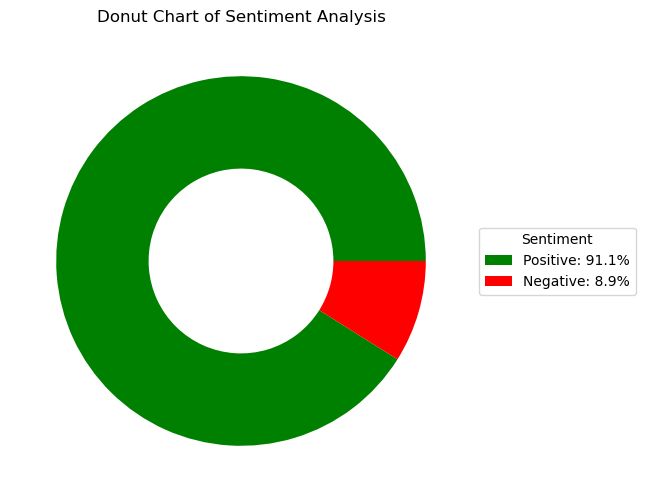

In [451]:
pos = pos_count # assigns positive sentiment count to pos
neg = neg_count # assigns negative sentiment count to neg

labels = ['Positive', 'Negative'] # defines labels for sentiment categories
values = [pos, neg] # stores sentiment counts in a list

percentages = [f'{label}: {value/sum(values)*100:.1f}%' for label, value in zip(labels, values)] # # calculates percentages for each sentiment category and formats them as strings (courtesy of chatgpt)

# creates donut chart
fig, ax = plt.subplots(figsize=(6, 6)) # initializes figure and axes with specified size
ax.pie(values, labels=None, wedgeprops=dict(width=0.5), colors=['green', 'red']) # plots a pie chart with sentiment values, sets width for donut effect, and assigns colors
ax.legend(percentages, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1)) # adds a legend with sentiment percentages and positions it to the right of the chart

ax.set_title('Donut Chart of Sentiment Analysis') # sets the chart title

plt.show() # displays the chart

#### ———  comparision of TextBlob and NaiveBayesAnalyzer results 

The donut chart using TextBlob analysis categorizes sentiments into Positive (83.3%), Negative (8.3%), and Neutral (8.3%), providing a more detailed perspective that highlights a significant portion of positive and neutral reviews. On the other hand, the NaiveBayesAnalyzer focuses on a dual classification, showing Positive (67.7%) and Negative (24.6%), without accounting for neutrality, resulting in a sharper division of opinions. This suggests that  TextBlob offers a more detailed sentiment breakdown, which could be useful for determining customer satisfaction in detail. NaiveBayesAnalyzer emphasizes a clearer divide between positive and negative reviews, which could be useful for quickly determining overall customer satisfaction for the crepe places.

#### ———  removing NLTK stop-words

↓ code to clean up the reviews using the NLTK stop-words library - reads the reviews from a file, parses them, and cleans

In [413]:
file_path = 'business_reviews.txt' # specifies the file containing business reviews

with open(file_path, 'r') as file: # opens the file in read mode
    content = file.read() # reads the entire file content

reviews = [] # initializes an empty list to store reviews

stop_words = set(stopwords.words('english')) # loads english stop words using NLTK

def remove_stop_words(text): # function to remove stop words from the given text
    words = word_tokenize(text.lower()) # tokenizes and converts text to lowercase
    filtered_words = [] # initializes an empty list for filtered words
    for word in words: # iterates through each word
        if word.isalnum() and word not in stop_words: # checks if word is alphanumeric and not a stop word
            filtered_words.append(word) # adds the filtered word to the list
    return ' '.join(filtered_words) # joins filtered words into a single string

buisness_reviews = [] # initializes a list to store business names and their reviews
sections = content.split("=================\n") # splits content into sections based on separator

for section in sections: # iterates through each section
    if "Business Name:" in section: # checks if section contains business name
        buisness_name = section.split("Business Name:")[1].split("\n")[0].strip() # extracts and strips the business name
        review_section = section.split("Reviews:")[-1].strip() # extracts and strips review section
        indi_reviews = review_section.split("• ")[1:] # splits individual reviews
        cleaned_reviews = [] # initializes a list for cleaned reviews
        for review in indi_reviews: # iterates through each review
            review_text = review.split("Sentiment:")[0].strip() # extracts review text before sentiment
            cleaned_reviews.append(remove_stop_words(review_text)) # appends cleaned review text
        buisness_reviews.append((buisness_name, cleaned_reviews))  # adds business name and its cleaned reviews to the list

i = 1 # initializes review counter
output_file = 'cleaned_reviews.txt' # specifies the output file for the cleaned reviews
with open(output_file, 'w') as file: # opens the output file in write mode
    for buisness_name, reviews in buisness_reviews: # iterates through business reviews
        file.write(f"\n\nCleaned Reviews for {buisness_name}") # writes business name header
        print(f"\nCleaned Reviews for {buisness_name}") # prints business name header
        for review in reviews: # iterates through each cleaned review
            print(f"- Review {i}: {review}") # prints review with its index
            file.write(f"\n- Review {i}: {review}") # writes review to file with its index
            i += 1 # increments review counter
            if i == 4: # resets counter after three reviews
                i = 1

print(f"\n ✩ Cleaned reviews have been saved to {output_file}") # confirms that the cleaned reviews have been saved to the output file


Cleaned Reviews for El Coqui Crepes
- Review 1: like crepes place wife huge fan new restaurant denville like dream come true restaurant really
- Review 2: place absolutely adorable needed nestled heart denville true puerto rican gem limited time barbie
- Review 3: live new jersey place must try absolutely love decor beautiful place love swing treat

Cleaned Reviews for Noon Tea Creperie
- Review 1: delicious thai milk tea tried times service quick friendly space sit inside fills quick love spot
- Review 2: small cozy little bubble tea place drink average dont see anything special place would recommend similar bubble
- Review 3: know preorder 3 inches crepe cakes two days advance already disappointed start visit big deal

Cleaned Reviews for T-Swirl Crêpe
- Review 1: busy cute cozy spot get sweet savory crepe fix offer wide variety occasionally see new items menu beautiful setting
- Review 2: every bf gets us reservations fancy dinner area kind food amazing still hungry end
- Review 3:

#### ———  code for WordCloud 

↓ code to generate a WordCloud of the top 20 words used in the reviews

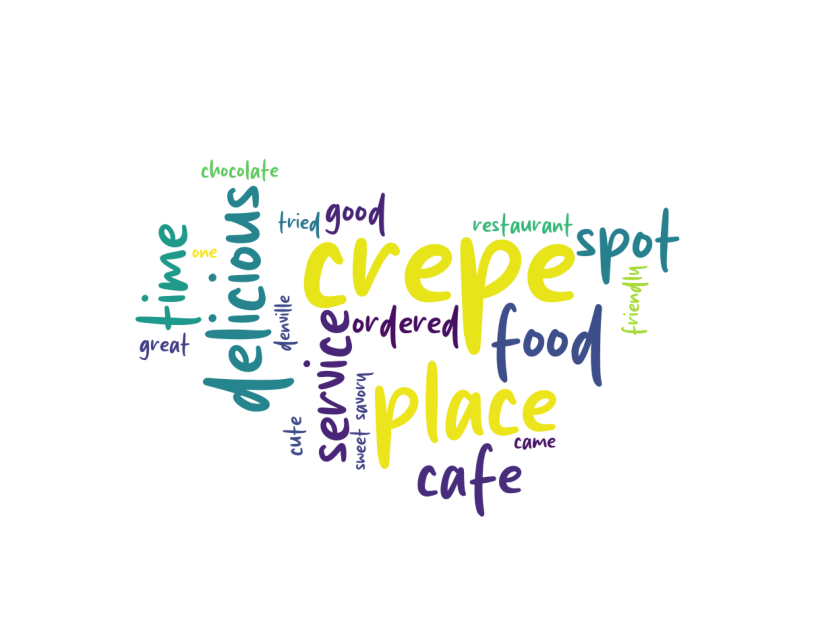

In [416]:
file_path = 'cleaned_reviews.txt' # specifies the file containing cleaned reviews
mask = np.array(Image.open('crepe-image.png')) # loads image as a numpy array to use as a mask for word cloud

with open(file_path, 'r') as file: # opens the file in read mode
    content = file.read() # reads the entire file content

reviews_only = re.findall(r'Review \d+: (.+?)(?=Review \d+:|Cleaned Reviews for |$)', content, re.DOTALL) # pattern matches the review text using regex, extracts text after 'Review X' and stops extracting for a buisness before 'Cleaned Reviews for', re.DOTALL ensures multiline matches (courtesy of chatgpt)

reviews_text = ' '.join(reviews_only) # joins all reviews into a single string

wordcloud = WordCloud( # initializes WordCloud object with specific parameters
                background_color ='white', # sets background color to white
                mask=mask, # applies the image mask for word cloud shape
                width=mask.shape[1], # sets the width of the word cloud based on mask dimensions
                height=mask.shape[0], # sets the height of the word cloud based on mask dimensions
                font_path='sunfish-original.otf', # specifies the font for the word cloud
                max_words = 20, # limits the number of words displayed
                min_font_size = 10 # sets the minimum font size
                ).generate(reviews_text) # generates word cloud using the reviews text
 
# plots the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None) # creates a figure with specified size and no face color
plt.imshow(wordcloud) # displays the word cloud on the figure
plt.axis("off") # hides the axis for a cleaner look
plt.tight_layout(pad = 0) # removes padding around the plot
 
plt.show() # displays the plot

#### ———  conclusion of insights i learned from this analysis

From this analysis, it is evident that the overall sentiment of reviews for the twenty crepe places is positive. Using TextBlob, 85% of the reviews were classified as positive, highlighting a strong approval trend among customers. The NaiveBayesAnalyzer analysis showed a similar result, with 76.7% of the reviews being positive. After removing NLTK stop-words, the WordCloud revealed that the most frequently used words included "good," "delicious," "cute," "great," and "sweet." These terms not only convey satisfaction but also suggest an enjoyable experience, supporting the positive narrative. Notably, none of the top twenty words carried negative connotations. Overall, this data highlights the enjoyment customers experienced at the crepe places analyzed.